## Preamble



This notebook make use of [GetDist](https://getdist.readthedocs.io/en/latest/) python package to plot and to analyse MCMC samples.



In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from getdist import plots, loadMCSamples

Print version used



In [4]:
import matplotlib as mpl
import getdist
print("     Numpy :", np.__version__)
print("Matplotlib :", mpl.__version__)
print("   GetDist :", getdist.__version__)

     Numpy : 1.16.3
Matplotlib : 3.1.0
   GetDist : 1.0.0


## Definitions



Define CMB & nuisance parameter names.



In [5]:
cosmo_params = [
    "cosmomc_theta",
    "logA",
    "ns",
    "ombh2",
    "omch2",
    "H0",
    "Alens",
    "tau"
]
nuisance_params = [
    "a_tSZ",
    "a_kSZ",
    "a_p",
    "beta_p",
    "a_c",
    "beta_c",
    "a_s",
    # "n_CIBC",
    # "T_d"
]

## MCMC chains



Have a look at how chains evolve with time and check convergence or not.



In [6]:
def plot_chains(file_root, params, nrow=None, ncol=None):
  import glob
  files = sorted(glob.glob(file_root + "*.txt"))

  nrow = len(params)//2 if nrow is None else nrow
  ncol = len(params)//2 if ncol is None else ncol
  plt.figure(figsize=(15, 10))
  ax = [plt.subplot(nrow, ncol, i+1) for i in range(len(params))]

  # Loop over files independently
  for f in files:
    sample = loadMCSamples(f[:-4])
    color = "C{}".format(f.split(".")[-2])

    # Get param values
    values = sample.getParams()

    # Get associated LaTeX labels
    labels = sample.paramNames.parsWithNames(params)
    for i, p in enumerate(params):
      ax[i].set_ylabel(labels[i].latexLabel())
      ax[i].plot(getattr(values, p), alpha=0.75, color=color)

  plt.tight_layout()

Plot chains for the CMB & nuisance parameters given a simulation id (up to 9 so far)



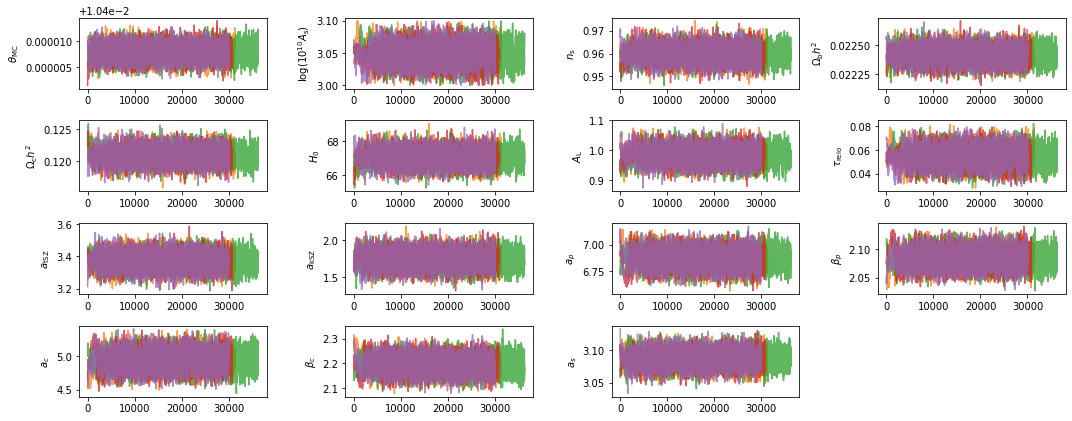

In [19]:
sim_id = 0
plot_chains("./data/tt-te-ee_fg-tt/sim_{}/mcmc".format(sim_id), params=cosmo_params+nuisance_params, ncol=4)

## MCMC distributions



Load the different chains into one weighted sample with burnin corresponding to 40% of the chains.



In [20]:
sim_id = 0
sample = loadMCSamples("./data/tt-te-ee_fg-tt/sim_{}/mcmc".format(sim_id),
                       settings={"ignore_rows": 0.4})

Show input values from simulation.



In [21]:
inputs = {
    "cosmomc_theta": 0.0104085,
    "logA": 3.044,
    "ombh2": 0.02237,
    "omch2": 0.1200,
    "ns": 0.9649,
    "Alens": 1.0,
    "tau": 0.0544,
    "H0": 67.36,
    "a_tSZ": 3.30,
    "a_kSZ": 1.60,
    "a_p": 6.90,
    "beta_p": 2.08,
    "a_c": 4.90,
    "beta_c": 2.20,
    "n_CIBC": 1.20,
    "a_s": 3.10,
    "T_d": 9.60
}
def show_input(g, params):
    for i, p in enumerate(params):
        x = inputs.get(p, np.nan)
        kwargs = dict(color="gray", ls="--", lw=1)
        for ax in g.subplots[:,i]:
            if ax: ax.axvline(x, **kwargs)
        for ax in g.subplots[i,:i]:
            if ax: ax.axhline(x, **kwargs)

Define global plot settings



In [22]:
from getdist.plots import GetDistPlotSettings
plot_settings = GetDistPlotSettings()
plot_settings.num_plot_contours = 3
plot_settings.solid_colors = "tab10"
plot_settings.line_styles = "tab10"

### Triangle plot



Plot posterior distributions of CMB parameters



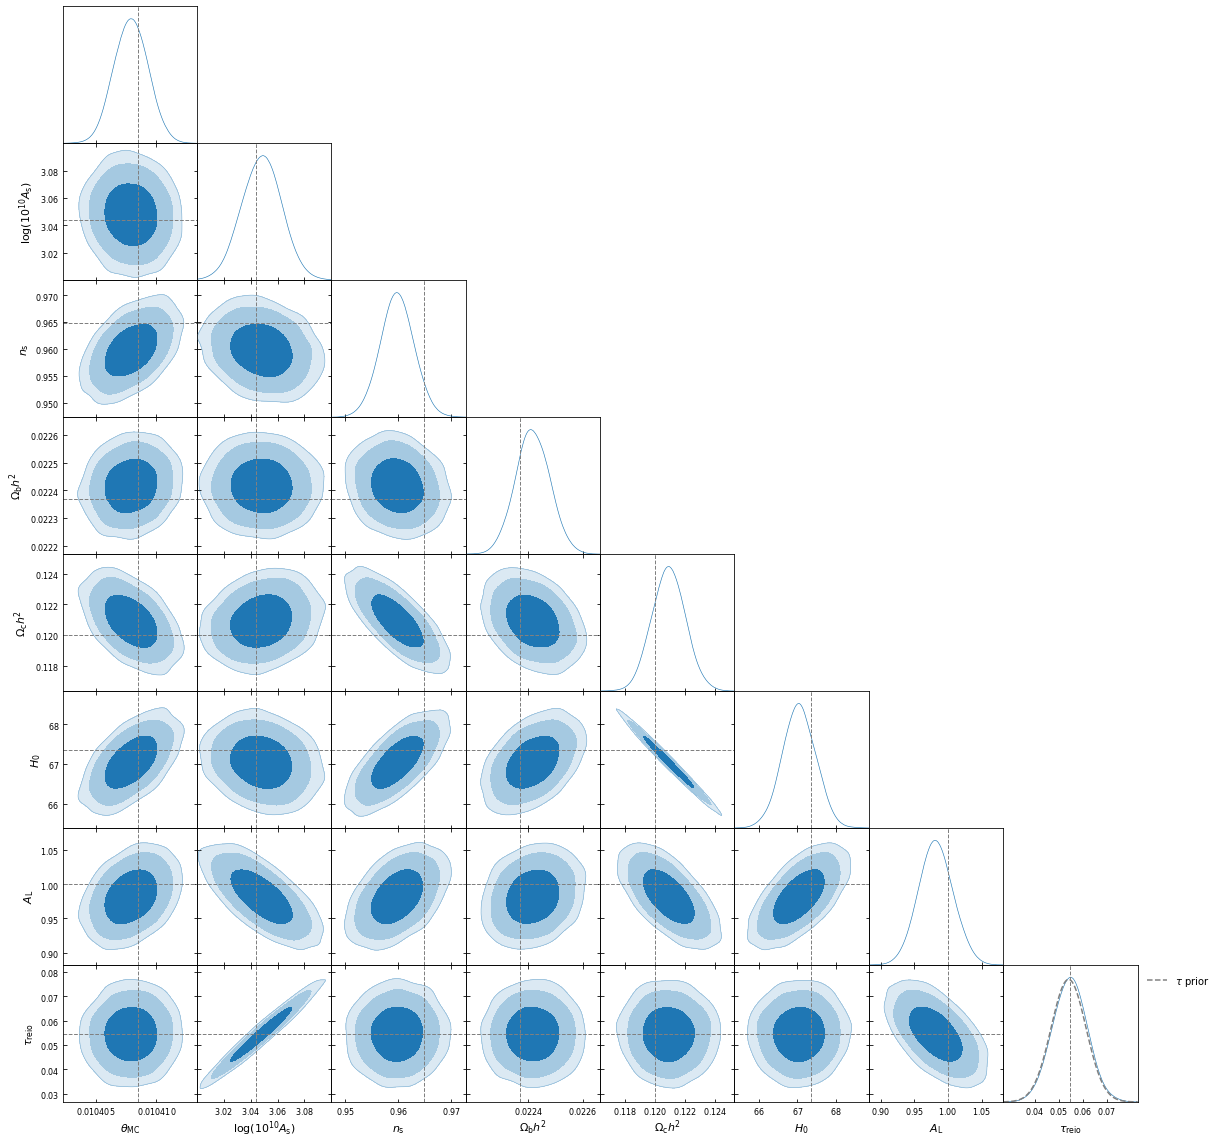

In [24]:
g = plots.get_subplot_plotter(settings=plot_settings)
g.triangle_plot(sample, cosmo_params, filled=True,
                colors=["C0"], diag1d_kwargs={"colors":["C0"]})
# Show input value
show_input(g, cosmo_params)
# Show prior on tau
ax = g.subplots[-1, -1]
xmin, xmax, ymin, ymax = ax.axis()
x = np.linspace(xmin, xmax, 100)
from scipy.stats import norm
ax.plot(x, 0.018*norm.pdf(x, 0.054, 0.0073), color="gray", ls="--", label=r"$\tau$ prior")
ax.legend(loc="upper left", bbox_to_anchor=(1,1))

Do the same for nuisance parameters



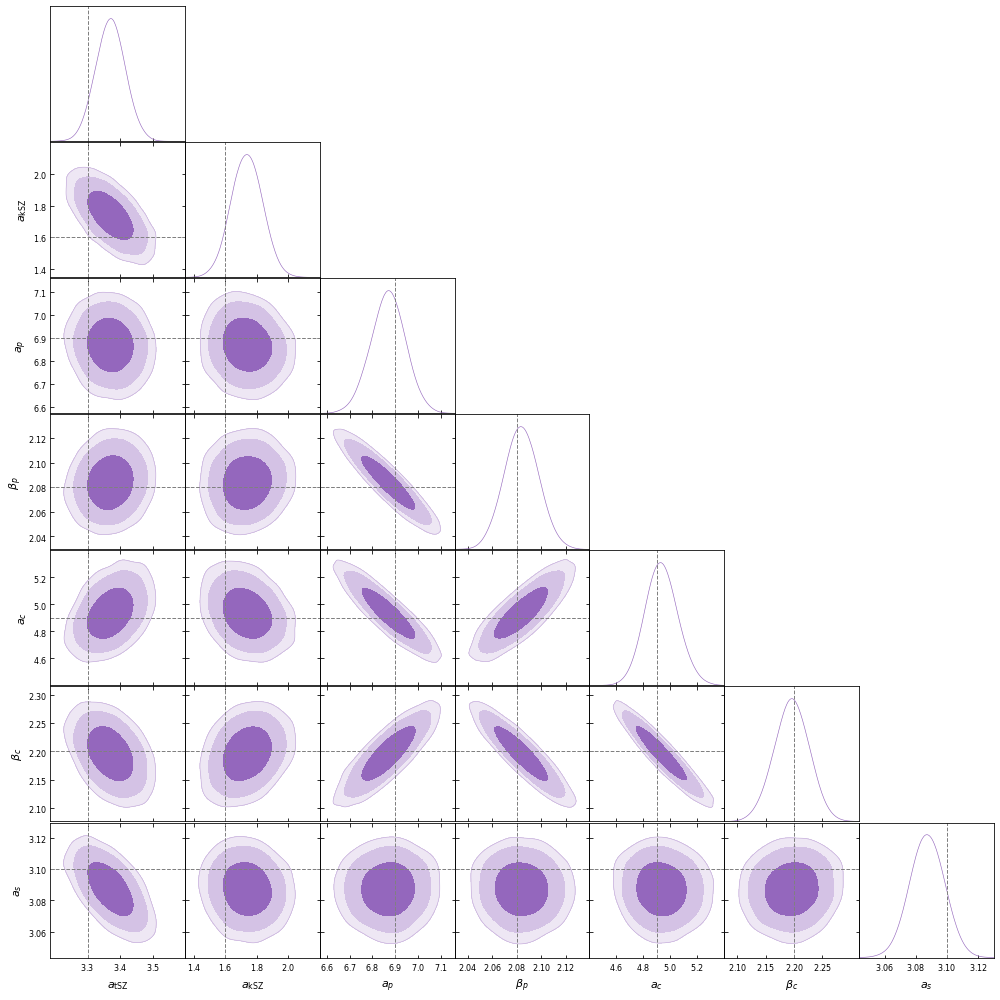

In [26]:
g.triangle_plot(sample, nuisance_params, filled=True,
                colors=["C4"], diag1d_kwargs={"colors":["C4"]})
show_input(g, nuisance_params)

### Table



Fisher results



In [13]:
fisher = {
    "cosmomc_theta": 1.4486065596773747e-06,
    "logA": 0.0036317591906040248,
    "ombh2": 6.536685599536575e-05,
    "omch2": 0.0011424383079735975,
    "ns": 0.0032727928988092654,
    "Alens": 0.02218573265886299,
    "tau": None,
    "H0": None,
    "a_tSZ": 0.0458633315116957,
    "a_kSZ": 0.10197033488579488,
    "a_p": 0.07612743384341107,
    "beta_p": 0.014099541556253719,
    "a_c": 0.12237773103689452,
    "beta_c":0.03130983994013702,
    "n_CIBC": None,
    "a_s": 0.011254308374681048,
    "T_d": None

}

Show table for mean value and standard deviations



In [28]:
from IPython.display import HTML, display
import tabulate
table = sample.getTable().tableParamNames
results = [[par.latexLabel(), par.mean, par.err, fisher[table.name(j)]]
            for j, par in enumerate(table.names)
            if table.name(j) in cosmo_params+nuisance_params]
display(HTML(tabulate.tabulate(results, headers=["Parameter", "mean", "std.", "fisher"], tablefmt="html")))

Parameter,mean,std.,fisher
$\theta_\mathrm{MC}$,0.0104079,1.42449e-06,1.44861e-06
$\log(10^{10} A_\mathrm{s})$,3.04818,0.0149756,0.00363176
$n_\mathrm{s}$,0.959824,0.00323019,0.00327279
$\Omega_\mathrm{b}h^2$,0.0224158,6.40752e-05,6.53669e-05
$\Omega_\mathrm{c}h^2$,0.120892,0.00112531,0.00114244
$A_\mathrm{L}$,0.981871,0.0258391,0.0221857
$\tau_\mathrm{reio}$,0.0545363,0.00730931,
$a_\mathrm{tSZ}$,3.37069,0.0461286,0.0458633
$a_\mathrm{kSZ}$,1.73616,0.100987,0.10197
$a_p$,6.86901,0.0769267,0.0761274


### Results from all simulations



Load the different samples



In [29]:
samples = [loadMCSamples("./data/tt-te-ee_fg-tt/sim_{}/mcmc".format(sim_id),
                         settings={"ignore_rows": 0.4}) for sim_id in range(10)]

Function to plot (mean, std) for all the simulations given input value and Fisher variances.



In [30]:
def plot_sim_results(params, color="C0"):

    fig, ax = plt.subplots(1, len(params), sharey=True, figsize=(20, 7))
    plt.subplots_adjust(hspace=0, wspace=0.15)
    plt.yticks([])

    chi2s = np.empty((len(params), len(samples)))
    for i, sample in enumerate(samples):
        marge = sample.getMargeStats()
        for j, name in enumerate(params):
            par = marge.parWithName(name)
            x = par.mean
            xerr = par.err
            markers, caps, bars = ax[j].errorbar(x, i, xerr=xerr, fmt="o{}".format(color),
                                                 ecolor=color, elinewidth=3)
            [bar.set_alpha(0.5) for bar in bars]
            chi2s[j, i] = ((x - inputs[name])/xerr)**2

    # Customize axes and labels
    for j, name in enumerate(params):
        ax[j].spines["right"].set_color(None)
        ax[j].spines["top"].set_color(None)
        ax[j].tick_params(bottom="off")
        label = samples[0].getLatex(params)[0][j]
        ax[j].set_xlabel(r"${}$".format(label))
        x = inputs[name]
        ax[j].spines["left"].set_position(("data", x))
        sigma = fisher[name]
        if sigma:
            ax[j].axvspan((x - sigma), (x + sigma), color="gray", alpha=0.15)
        from scipy.stats import chi2
        ax[j].set_title("$P(\chi^2)$ = {0:.3f}".format(chi2.sf(np.sum(chi2s[j]), len(chi2s[j]))))

CMB parameters



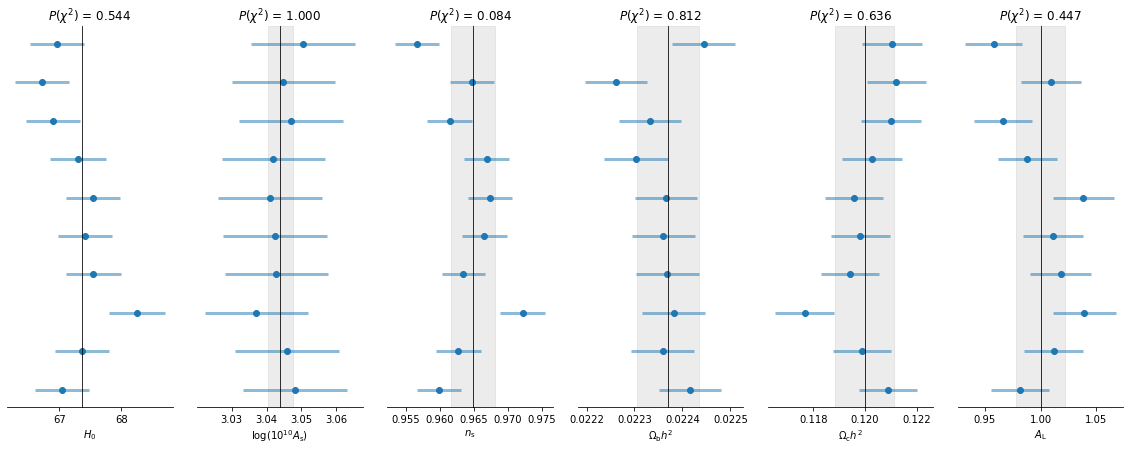

In [32]:
plot_sim_results(["H0", "logA", "ns", "ombh2", "omch2", "Alens"])

Nuisance parameters



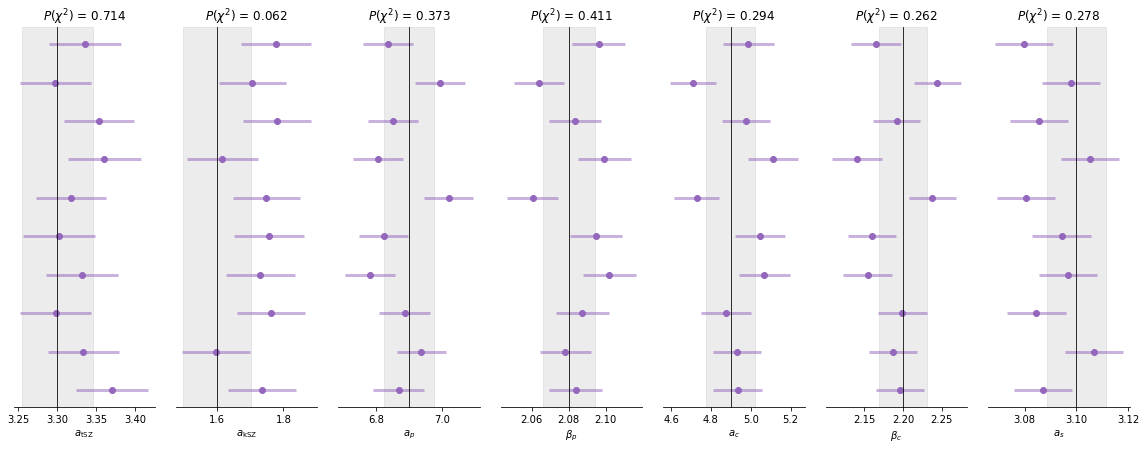

In [18]:
plot_sim_results(nuisance_params, color="C4")